In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pywt
from PIL import Image  
import PIL  
from skimage.io import imsave, imread

In [3]:
from dask import bag, diagnostics 
#import hvplot.pandas
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import shutil

import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, zero_one_loss, classification_report
import seaborn as sns
from tensorflow import keras
import matplotlib.cm as cm
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from keras.layers import Input
from keras.layers import Convolution2D , concatenate ,Conv2D,Dense
from keras.layers import Activation,Dropout, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam ,SGD,RMSprop

In [5]:
import math
from keras.layers import MaxPool2D, concatenate, AveragePooling2D
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py
from keras.layers import Concatenate
import keras.backend as K
import keras
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler

In [6]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import imutils

In [8]:
data_path = '/content/drive/MyDrive/Sem 2/CV/5G_Data/'

In [14]:
directories = {
    '4QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data/4QAM/',
    '8QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data/8QAM/',
    '16QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data/16QAM/',
    '32QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data/32QAM/',
    '64QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data/64QAM/',}

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
classes = list(os.listdir('/content/drive/MyDrive/Sem 2/CV/5G_Data/'))
print(classes)

['4QAM', '64QAM', '16QAM', '32QAM', '8QAM']


In [ ]:
!mkdir /content/drive/MyDrive/5G_Data/TRAIN /content/drive/MyDrive/5G_Data/TEST /content/drive/MyDrive/5G_Data/TRAIN/4QAM /content/drive/MyDrive/5G_Data/TRAIN/8QAM /content/drive/MyDrive/5G_Data/TRAIN/16QAM /content/drive/MyDrive/5G_Data/TRAIN/32QAM /content/drive/MyDrive/5G_Data/TRAIN/64QAM /content/drive/MyDrive/5G_Data/TEST/4QAM /content/drive/MyDrive/5G_Data/TEST/8QAM /content/drive/MyDrive/5G_Data/TEST/16QAM /content/drive/MyDrive/5G_Data/TEST/32QAM /content/drive/MyDrive/5G_Data/TEST/64QAM


In [ ]:
!ls

In [16]:
# get image dimensions
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w

[########################################] | 100% Completed | 11.46 s
[########################################] | 100% Completed | 14.11 s
[########################################] | 100% Completed | 6.21 s
[########################################] | 100% Completed | 9.13 s
[########################################] | 100% Completed | 10.95 s


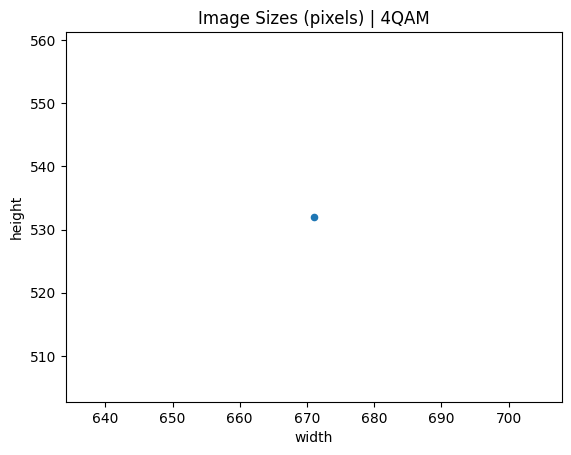

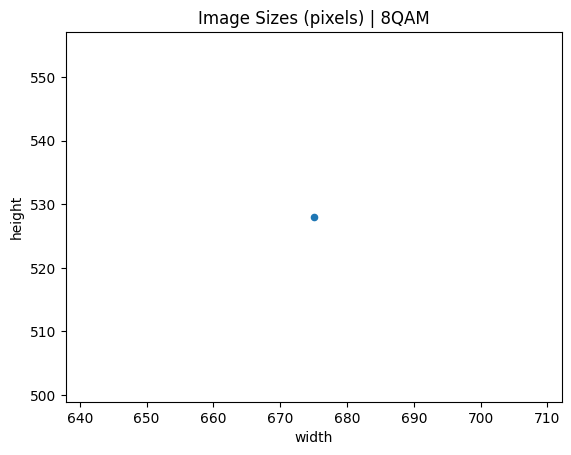

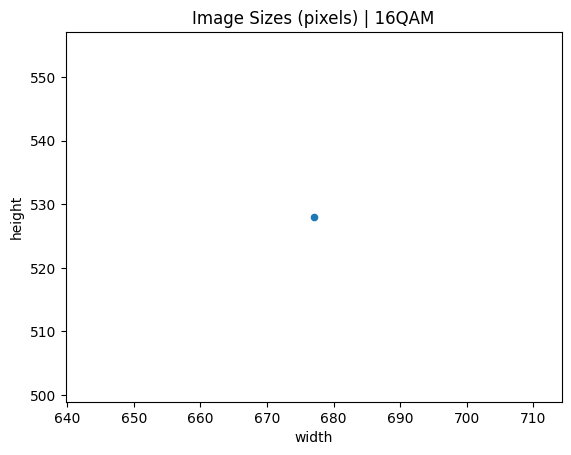

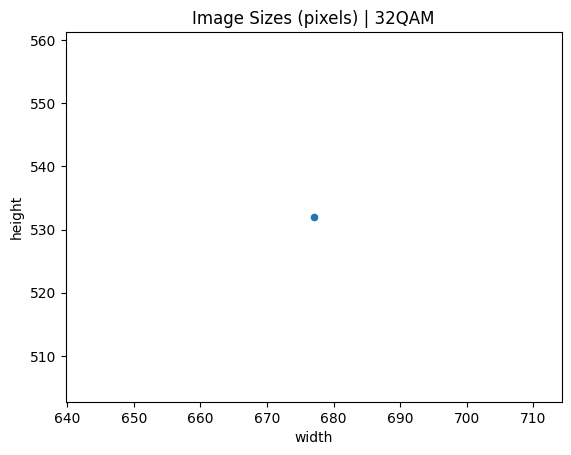

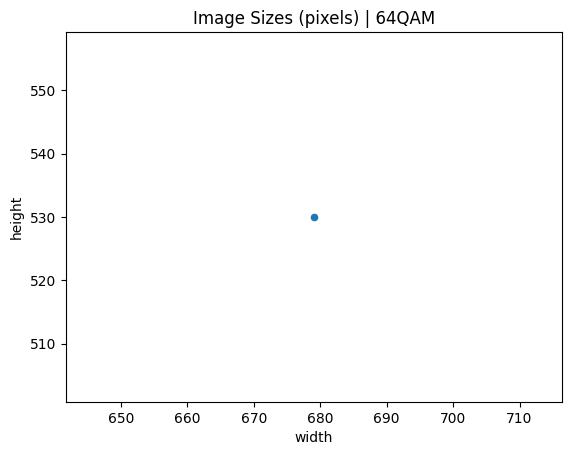

In [17]:
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(filelist).map(get_dims)
  with diagnostics.ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

# **Scolograms**

In [18]:
def plot_samples(dir, label):
  from tensorflow.keras.preprocessing import image

  fig = plt.figure(figsize = (8,6))
  filelist = [filepath + f for f in os.listdir(dir)]
  files = np.random.choice(filelist, 6, replace = False)
  plt.title(label)
  plt.axis('off')

  for i in range(6):
      ax = fig.add_subplot(2, 3, i+1)
      fn = image.load_img(files[i], target_size = (100,100))
      plt.imshow(fn)
      plt.axis('off')
  plt.show()

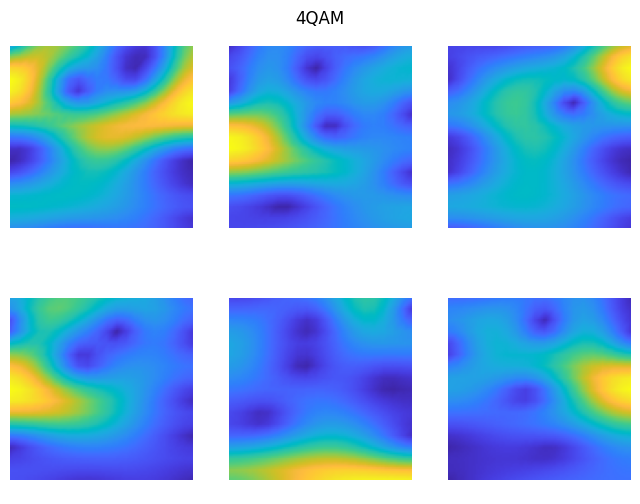

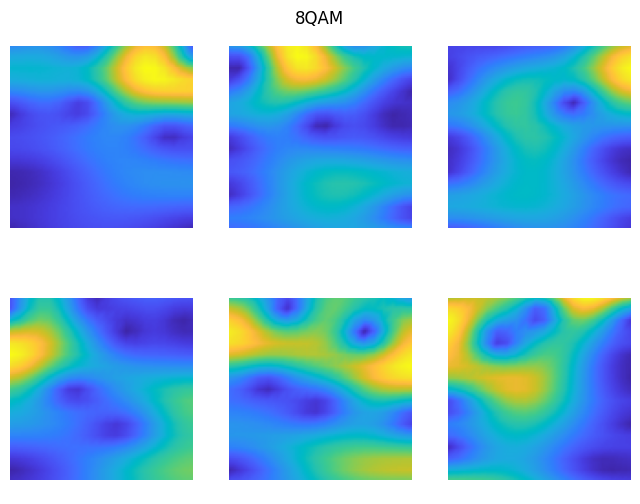

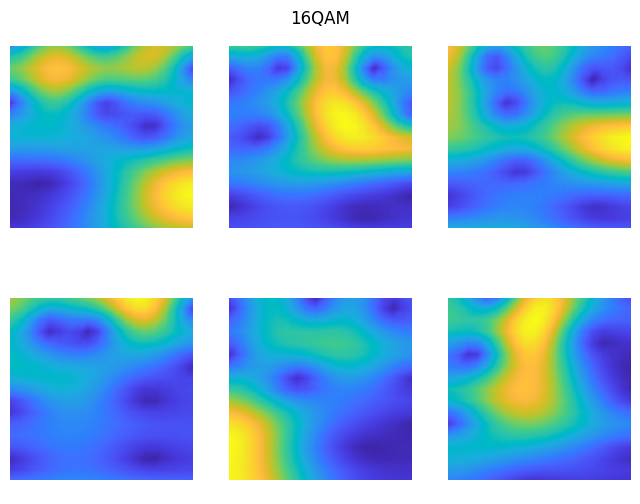

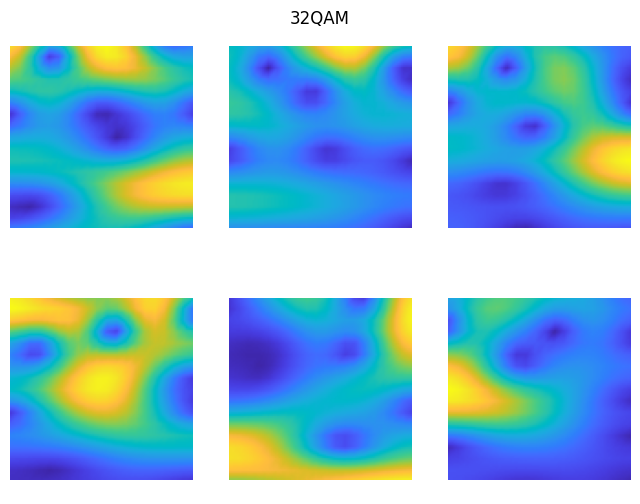

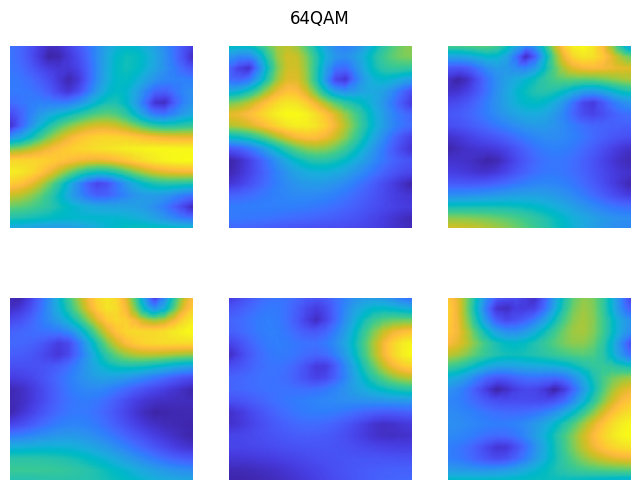

In [19]:
for n,dir in directories.items():
  plot_samples(d,n)

In [20]:
all_images = []
labels = []

for folder in classes:
    folder_path = os.path.join(data_path, folder)
    for filename in os.listdir(folder_path):
      all_images.append(os.path.join(folder_path, filename))
     
      if  folder in '4QAM':
        labels.append(0)
      elif folder in '32QAM':
        labels.append(3)
      elif folder in '16QAM':
        labels.append(2)
      elif folder in '8QAM':
        labels.append(1)
      elif folder in '64QAM':
        labels.append(4)

print(set(labels))

{0, 1, 2, 3, 4}


In [21]:
import torch
device = torch.device("cuda:0" if (torch.cuda.is_available() ) else "cpu")

In [22]:
# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 1455
Validation set size: 486
Test set size: 61


In [23]:
def preprocess_images(images):
    preprocessed_images = []
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        preprocessed_images.append(new_img)
    return np.array(preprocessed_images)

In [24]:
# Apply the preprocessing to all the data subsets 
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

In [25]:
# Transform the subsets to numpy arrays 
X_train = np.array([image for image in X_train_pre])
X_val = np.array([image for image in X_val_pre])
X_test = np.array([image for image in X_test_pre])

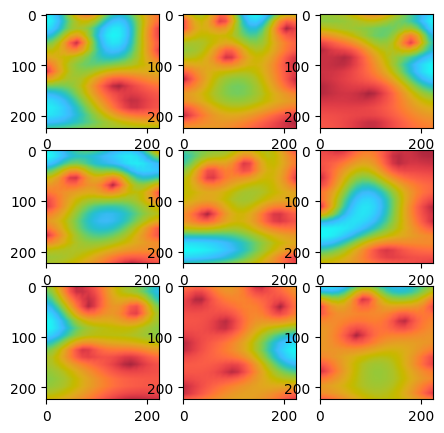

In [26]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
plt.show()

In [27]:
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_val = pd.Series(y_val)

In [29]:
X_train.shape

(1455, 224, 224, 3)

In [30]:
y_train[:10]

0    3
1    1
2    4
3    0
4    4
5    4
6    2
7    1
8    0
9    2
dtype: int64

In [31]:
y_train.shape

(1455,)

In [32]:
X_test.shape

(61, 224, 224, 3)

In [33]:
y_test.shape

(61,)

In [34]:
IMG_SIZE = 224

# **VGG Model**

In [35]:
#import required libraries — we do need the models, flatten, dense, input layers 
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [36]:

IMAGE_SIZE = [224, 224] #Default image size for VGG16

In [45]:
#Create a VGG16 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
#vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights
# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 


vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
x = Dropout(0.3)(x)
x = Dense(30, activation='relu')(x)
prediction = Dense(len(classes), activation='softmax')(x) # We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes
#Creating model object 
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [46]:
#opt = keras.optimizers.Adam(learning_rate=0.01)
opt = tf.keras.optimizers.experimental.SGD(0.1, momentum=0.9)

#opt = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.1)

#Compile the model 
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer= opt, 
              metrics=['accuracy']) 

In [47]:
es = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=25,
        verbose=1)
]

In [48]:
device

device(type='cuda', index=0)

In [49]:
history = model.fit(X_train,
                    y_train,
                    epochs= 60,
                    validation_data = (X_val,y_val),
                    verbose = 1,
                    #callbacks = [es],
                    batch_size=32)

Epoch 1/60
46/46 [==============================] - 10s 200ms/step - loss: 11544.4072 - accuracy: 0.1952 - val_loss: 1.6159 - val_accuracy: 0.1831
Epoch 2/60
46/46 [==============================] - 9s 197ms/step - loss: 1.6191 - accuracy: 0.1869 - val_loss: 1.6106 - val_accuracy: 0.2099
Epoch 3/60
46/46 [==============================] - 9s 207ms/step - loss: 1.6180 - accuracy: 0.1863 - val_loss: 1.6137 - val_accuracy: 0.2099
Epoch 4/60
46/46 [==============================] - 10s 209ms/step - loss: 1.6177 - accuracy: 0.1952 - val_loss: 1.6075 - val_accuracy: 0.2099
Epoch 5/60
46/46 [==============================] - 9s 202ms/step - loss: 1.6161 - accuracy: 0.1780 - val_loss: 1.6100 - val_accuracy: 0.2099
Epoch 6/60
46/46 [==============================] - 9s 205ms/step - loss: 1.6140 - accuracy: 0.1924 - val_loss: 1.6138 - val_accuracy: 0.1872
Epoch 7/60
46/46 [==============================] - 9s 203ms/step - loss: 1.6142 - accuracy: 0.2000 - val_loss: 1.6091 - val_accuracy: 0.2099


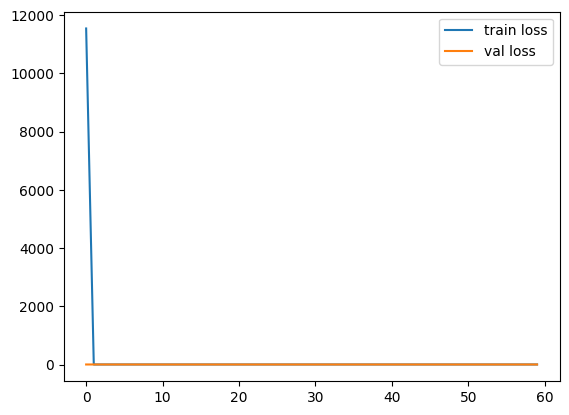

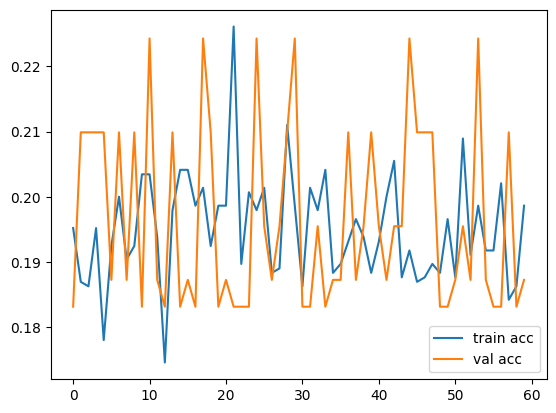

In [50]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
 
 # accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [51]:
from tensorflow.keras.models import load_model
model.save('5G_vgg16.h5')

In [ ]:
print(classes)
print(y_test[:25], '\n')
print(y_pred[:25], '\n')

# predict = []
# for i in range(3000): #len(y_pred)
#   predict.append(np.argmax(y_pred[i]))

# print(predict[:25], '\n')

cm = confusion_matrix(y_test, y_pred)
print(cm, '\n')

zol = zero_one_loss(y_test, y_pred, normalize = False)
print(zol, '\n')

cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()